<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/efficient_sampled_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient Sampled Softmax

In [1]:
%tensorflow_version 1.x
import tensorflow as tf

def subsampled_softmax(target_embed_kernel,labels,inputs_embed,samples_ids,labels_prior,samples_prior):
  '''
    computes sampled softmax loss, given class embeddings, true labels, embeded inputs and samples with priors 
    the output is per batch, not reduced !
  '''
  with tf.variable_scope('subsampled_softmax'):

    with tf.variable_scope('target_embeddings'):
      samples_embed = tf.gather(target_embed_kernel,samples_ids) # (N_SAMPLED,N_EMBED)
      labels_embed = tf.gather(target_embed_kernel,labels,axis=0) # (N_BATCH,N_EMBED)

    with tf.variable_scope('labels_logits'):
      labels_logits = tf.matmul(tf.expand_dims(labels_embed,1),tf.expand_dims(inputs_embed,-1)) # (N_BATCH,1,1)
      labels_logits = tf.squeeze(labels_logits,-1) # N_BATCH,1
      labels_logits = labels_logits-tf.log(labels_prior) # add prior-correction

    with tf.variable_scope('sampl_logits'):
      samples_logits = tf.matmul(inputs_embed,samples_embed,transpose_b=True) # (N_BATCH,N_SAMPLED)
      samples_logits = samples_logits-tf.log(samples_prior) # add prior-correction
      
    with tf.variable_scope('sampl_loss'):
      candidate_logits = tf.concat([samples_logits,labels_logits],axis=-1) # (N_BATCH,N_SAMPLED+1)
      Z = tf.reduce_logsumexp(candidate_logits,axis=-1,keepdims=True) # (N_BATCH,1)
      loss = -labels_logits + Z 
      loss = tf.squeeze(loss,-1)

    return loss

TensorFlow 1.x selected.


# Test correctness

In [2]:
tf.reset_default_graph()
import numpy as np

## random data to check correctness, synthetic word2vec problem

N_BATCH = 32
N_WORDS = 10000
N_EMBED = 300
N_SAMPLED = 100

inputs = tf.placeholder(tf.int64,[None])
labels = tf.placeholder(tf.int64,[None])
#tf.random.uniform([N_BATCH],0,N_WORDS,dtype=tf.int64)
#tf.random.uniform([N_BATCH],0,N_WORDS,dtype=tf.int64)

input_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
target_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32)
target_embed_bias = tf.zeros(N_WORDS)
inputs_embed = tf.gather(input_embed_kernel,inputs) # (N_BATCH,N_EMBED)

samples_ids,labels_prior,samples_prior = tf.random.uniform_candidate_sampler(tf.expand_dims(inputs,-1),1,N_SAMPLED,False,N_WORDS)

## our optimized loss
loss = subsampled_softmax(target_embed_kernel,
                          labels,inputs_embed,
                          samples_ids,labels_prior,samples_prior)

loss = tf.reduce_mean(loss)

## tensorflow loss - note it is not reduced accross batch
loss_tf = tf.nn.sampled_softmax_loss(target_embed_kernel,target_embed_bias,
                                  labels,inputs_embed,
                                  N_SAMPLED,N_WORDS,1,
                                  (samples_ids,labels_prior,samples_prior),
                                  False)

loss_tf = tf.reduce_mean(loss_tf)

init_randomness = tf.global_variables_initializer()

with tf.Session() as sess:
  for _ in range(10):
    # refresh randomness every time
    sess.run(init_randomness)
    inputs_batch,labels_batch = np.random.randint(0,N_WORDS,[2,N_BATCH],np.int64)
    feed_dict = {inputs:inputs_batch,labels:labels_batch}
    # compute both losses and compare
    loss1,loss2 = sess.run([loss_tf,loss],feed_dict)
    np.testing.assert_array_almost_equal(loss1,loss2,5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Compare speed

We evaluate speed of both implementations for forward and backward passes.

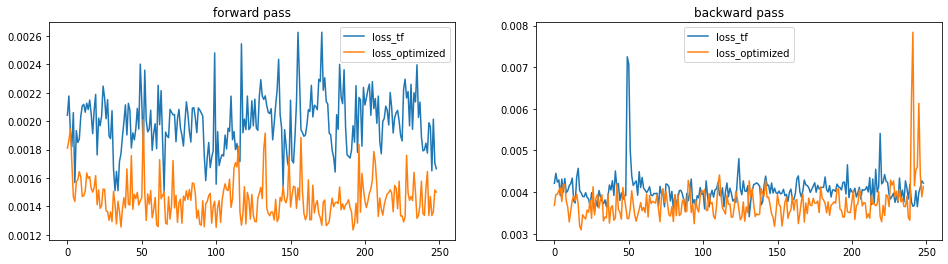

In [10]:
import time
from matplotlib import pyplot as plt

N_BATCH = 256

train_data = np.random.randint(0,1000,[250,2,N_BATCH],np.int64)

def get_timings(op,train_data):
  ''' does timings for a graph op several times '''
  with tf.Session() as sess:
    sess.run(init_randomness)
    times = []
    for inputs_batch,labels_batch in train_data:
      feed_dict = {inputs:inputs_batch,labels:labels_batch}
      time_start = time.time()
      sess.run(op,feed_dict)
      time_end = time.time()
      times.append(time_end-time_start)
  return np.array(times)

_,axs=plt.subplots(1,2,figsize=(16,4))

## evaluate forwad pass

for op,label in zip([loss_tf,loss],['loss_tf','loss_optimized']):
  timings = get_timings(op,train_data)  
  axs[0].plot(timings[1:],label=label)
axs[0].legend()
axs[0].set_title('forward pass')

## evaluate backward pass

variables = [input_embed_kernel,target_embed_kernel]
grads_loss_tf = tf.gradients([loss_tf],variables)
grads_loss = tf.gradients([loss],variables)

#minimize_loss_tf = #tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
#minimize_loss = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)

for op,label in zip([grads_loss_tf,grads_loss],['loss_tf','loss_optimized']):
  timings = get_timings(op,train_data)  
  axs[1].plot(timings[1:],label=label)
axs[1].legend()
axs[1].set_title('backward pass')

plt.show()

# Old notes

In [0]:
N_WORDS,N_EMBED,N_SAMPLED = 1000000,300,10

def word2vec_task():

  with tf.variable_scope('inputs'):
    inputs = tf.placeholder(tf.int64,[None])   

  with tf.variable_scope('labels'):  
    labels = tf.placeholder(tf.int64,[None])     

  with tf.variable_scope('candid_samples'):
    sampler = tf.random.uniform_candidate_sampler(tf.expand_dims(labels,-1),1,N_SAMPLED,False,N_WORDS,name='sampler_ids') # (N_SAMPLED,)
    samples_ids, labels_prior, sampled_prior = sampler

  with tf.variable_scope('embeddings'):
    input_sd = 0.01
    input_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32,name='input_embed_kernel')
    target_embed_kernel = tf.Variable(tf.random.normal([N_WORDS,N_EMBED],0,1),dtype=tf.float32,name='output_embed_kernel') # DO NOT TRANSPOSE !
    inputs_embed = tf.gather(input_embed_kernel,inputs) # (N_BATCH,N_EMBED)
    samples_embed = tf.gather(target_embed_kernel,sampled_ids) # (N_SAMPLED,N_EMBED)
    labels_embed = tf.gather(target_embed_kernel,labels,axis=0) # (N_BATCH,N_EMBED)


In [0]:
def backprop():
  with tf.variable_scope('backprop'):
    batch_len = tf.cast(tf.shape(inputs)[0],tf.float32)
    sampled_pred = tf.exp(sampled_logits-Z)/batch_len # (N_BATCH,N_SAMPLED)
    sampled_mass = tf.reduce_sum(sampled_pred,axis=-1,keepdims=True) # (N_BATCH,1)
    with tf.variable_scope('grad_input_embed'):
      grad_input_embed = tf.matmul(sampled_pred,sampled_embed) # (N_BATCH,N_EMBED)
      grad_input_embed = grad_input_embed - sampled_mass * labels_embed #+ 1e-3*inputs_embed
      grad_input_embed = tf.IndexedSlices(grad_input_embed, inputs, tf.shape(input_embed_kernel))
    with tf.variable_scope('grad_target_embed'):
      grad_target_embed1 = tf.matmul(sampled_pred,inputs_embed,transpose_a=True) # (N_SAMPLED,N_EMBED)
      grad_target_embed2 = -sampled_mass * inputs_embed # (N_BATCH,N_EMBED)
      grad_target_embed = tf.concat([grad_target_embed1,grad_target_embed2],0) # (N_BATCH+N_SAMPLED,N_EMBED)
      grad_target_embed = tf.IndexedSlices(grad_target_embed, tf.concat([sampled_ids,labels],0), tf.shape(target_embed_kernel))

def build():

  with tf.variable_scope('optimize'):
    variables = [input_embed_kernel,target_embed_kernel]
    grads = [grad_input_embed,grad_target_embed]
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    update_op = optimizer.apply_gradients([(grad_input_embed,input_embed_kernel)])
    minimize_op = optimizer.minimize(loss)  

  with tf.variable_scope('init'):
    init_op = tf.global_variables_initializer()